# SI 671 - Amazon Review Fraud Detection Project

# Cleanup & Feature Engineering
Notebook Intent: Clean up the textual fields and work on extracting features that might have interesting correlations / predictive likelihoods to help distinguish real and fake reviews.

# Disclaimer
- Writing this chunk as I copy things over to github
- Retrospectively seeing a lot of code here that violates the DRY Principle and should've been functionalized
- Archiving the code with that not-fixed but keep in mind if referencing in future

## Setup

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt')
nltk.download('wordnet') 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger') #POS Tag

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# df = pd.read_csv("amazon_reviews.txt", sep="\t")
df = pd.read_csv('drive/Shared drives/SI671 Project [Data Mining]/data/amazon_reviews.txt', sep='\t') 
print(f"{df.shape[0]} records")

df.head(3)

21000 records


,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...


## Quick Cleans: Pseudo-Bools to Binary

In [ ]:
#### Convert native labels to more intuitive and binary expression
df = df.rename(columns={'LABEL':'LEGIT'})
df.LEGIT = df.LEGIT.replace("__label1__",0).replace("__label2__",1)

#### Convert verified status to binary expression
df.VERIFIED_PURCHASE = df.VERIFIED_PURCHASE.replace("N",0).replace("Y",1)

In [ ]:
df.head(3)

,DOC_ID,LEGIT,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,0,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,0,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,0,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...


## General Cleaning for Textual Fields
- Standardize lowercase
- Tokenize review text (regexp tokenizer for now, can try to improve on the pattern)
- Remove the stopwords (using the NLTK English stopwords corpus)
- Check out stemmers and lemmers

Deciding on using a lemmer rather than a stemmer. Relevant Medium article <a href="https://medium.com/@gaurav5430/using-nltk-for-lemmatizing-sentences-c1bfff963258">here</a>. Moreso a part-of-speech-presevering measure, incase we want to play with that.

In [ ]:
def process_text(text_col):
    #### Note 1: using the \w+ pattern could throw numericals, possible negligible, possibly not
    #### Note 2: lemmer decided over stemmer due to potential POS preservation utility
    #### Note 3: Removing stopwords could throw mess with negation detection. 
    ####         ----> "not" in spot_words == True
    text_list = []
    stop_words = stopwords.words('english')
    tk = RegexpTokenizer('\w+')
    lemmer = WordNetLemmatizer()
    
    for review in text_col:
        a = review.lower()
        b = tk.tokenize(a)
        c = [i for i in b if i not in stop_words]
        ## d = [stemmer.stem(i) for i in c] ## e = [lemmer.lemmatize(i) for i in d]
        e = [lemmer.lemmatize(i) for i in c]
        
        text_list.append(e)
    return text_list


In [ ]:
#### converting to lowercase due to being an us-made feature
df["review_tokens"] = process_text(df.REVIEW_TEXT)

In [ ]:
df.head(3)

,DOC_ID,LEGIT,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,review_tokens
0,1,0,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...","[least, think, product, save, day, keep, aroun..."
1,2,0,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,"[lithium, battery, something, new, introduced,..."
2,3,0,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,"[purchased, swing, baby, 6, month, pretty, muc..."


In [ ]:
#### To reconstitute review tokens into a sentence, just do this:
df.review_tokens.apply(lambda x: " ".join(x))[:5]

0    least think product save day keep around case ...
1    lithium battery something new introduced marke...
2    purchased swing baby 6 month pretty much grown...
3    looking inexpensive desk calcolatur work every...
4    use twice week result great used teeth whiteni...
Name: review_tokens, dtype: object

## Feature Extraction Ideas

### Easy Generics Tier
- count(char length)
- count(word length)
- count(unique terms)
- maybe count(symbols in field)

In [ ]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Could also run REVIEW_TITLE through these, maybe after text_cleanup()  #
#### #### #### #### #### #### #### #### #### #### #### #### #### #### ####

def build_length_features(df):
    frame = df.copy()
    frame['body_char_len'] = frame['REVIEW_TEXT'].apply(lambda x: len(x))
    frame['body_word_len'] = frame['REVIEW_TEXT'].apply(lambda x: len(x.split()))
    frame['body_token_len'] = frame['review_tokens'].apply(lambda x: len(x))
    #### sets(list) ==> remove all duplicates, so len(set(list)) == unique term count
    frame['uniq_body_tokens'] = frame['review_tokens'].apply(lambda x: len(set(x)))
    return(frame)

In [ ]:
df = build_length_features(df=df)
df.head(3)

,DOC_ID,LEGIT,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,review_tokens,body_char_len,body_word_len,body_token_len,uniq_body_tokens
0,1,0,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...","[least, think, product, save, day, keep, aroun...",116,23,10,10
1,2,0,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,"[lithium, battery, something, new, introduced,...",404,69,40,36
2,3,0,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,"[purchased, swing, baby, 6, month, pretty, muc...",248,52,20,19


## King Helper Function 

In [ ]:
def contains_breakdown(df, term):
    #### Helper function to note proportional separation signals of term towards legitimacy or fraud
    try:
        total = df[df.REVIEW_TEXT.str.contains(term, case=False)]
        fake, legit = (total.LEGIT.value_counts()[0], total.LEGIT.value_counts()[1])
        print(f"[{term.upper()}] :: {total.shape[0]} results total")
        print(f"    Legit:\t{legit} \t----> {round(legit/total.shape[0]*100,4)}%")
        print(f"    Fake:\t{fake} \t----> {round(fake/total.shape[0]*100,4)}%\n")
    except:
        print("well, that wasn't supposed to happen")
        print(f"I guess {term} wasn't in there")

## Curiosities Features
Capitalization Features: 
- if(all-caps)
- if(all-lower)
- char-to-cap ratio
- title-casing-to-word ratio

Symbol Features:
- Emoji aren't used but the rare ASCII face like `^_^` will show up, seem ignorable
- maybe: count(?), count(!), count(??+), count(!!+)

Markdown/URL Features:
- if(contain URL)
- if(contain linebreak) --> formatting difference, are fakers using linebreaks / multi paragraph?
- if(contain other product link) --> `[[ASIN:B00GHS6INM Galaxseed Energy Bar Mix]]` -- ASIN is Amazon Standard ID Number
- if(contain video) --> `[[VIDEOID:mo2OZ6CA5YHCIPV]]`

In [ ]:
def build_case_symbol_features(df):
    # Also includes URL and Markdown features because why not
    frame = df.copy()
    frame['body_no_caps'] = frame['REVIEW_TEXT'].apply(lambda x: x.islower())
    frame['body_all_caps'] = frame['REVIEW_TEXT'].apply(lambda x: x.isupper())
    frame['body_cap_char%'] = frame['REVIEW_TEXT'].apply(lambda x: len([i for i in x if i.isupper()])/len(x))

    #### of all terms except "I", what percentage of terms are capital-initiated?
    frame['title_case%'] = frame['REVIEW_TEXT'].apply(lambda x: 
                                    sum([1 for i in x.split() if (i[0].isupper() and (i!="I"))]) / len(x.split()))

    #### If body contains URL or <br /> linebreak
    frame['url_in_body'] = frame.REVIEW_TEXT.str.contains('http|www\.|\.com|\.edu|\.gov|\.net|\.org', case=False)
    frame['linebreak_in_body'] = frame.REVIEW_TEXT.str.contains('<br />')

    #### If body contains reference to other product on Amazon
    frame['contains_ASIN'] = frame.REVIEW_TEXT.str.contains('\[\[asin', case=False)

    #### If body contains video content/reference
    frame['contains_video'] = frame.REVIEW_TEXT.str.contains('\[\[videoid', case=False)

    return(frame)

In [ ]:
df = build_case_symbol_features(df=df)
df.head(3)

,DOC_ID,LEGIT,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,review_tokens,body_char_len,body_word_len,body_token_len,uniq_body_tokens,body_no_caps,body_all_caps,body_cap_char%,title_case%,url_in_body,linebreak_in_body,contains_ASIN,contains_video
0,1,0,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...","[least, think, product, save, day, keep, aroun...",116,23,10,10,False,False,0.017241,0.086957,False,False,False,False
1,2,0,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,"[lithium, battery, something, new, introduced,...",404,69,40,36,False,False,0.009901,0.043478,False,True,False,False
2,3,0,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,"[purchased, swing, baby, 6, month, pretty, muc...",248,52,20,19,False,False,0.024194,0.057692,False,False,False,False


In [ ]:
#### No-Caps seems pretty balanced, but All-Caps skews legit somehow.
#### Overall, both seem relatively low-frequency, though.
if(0):
    print(df[df.body_all_caps==True].LEGIT.value_counts())
    print()
    print(df[df.body_no_caps==True].LEGIT.value_counts())

In [ ]:
for each in ['!','!!','!!!','!!!!','!!!!!']:
    contains_breakdown(df=df, term=each)

[!] :: 5636 results total
    Legit:	2715 	----> 48.1725%
    Fake:	2921 	----> 51.8275%

[!!] :: 927 results total
    Legit:	462 	----> 49.8382%
    Fake:	465 	----> 50.1618%

[!!!] :: 496 results total
    Legit:	264 	----> 53.2258%
    Fake:	232 	----> 46.7742%

[!!!!] :: 149 results total
    Legit:	82 	----> 55.0336%
    Fake:	67 	----> 44.9664%

[!!!!!] :: 54 results total
    Legit:	33 	----> 61.1111%
    Fake:	21 	----> 38.8889%



In [ ]:
for each in ['\?','\?\?','\?\?\?']:
    contains_breakdown(df=df, term=each)

[\?] :: 762 results total
    Legit:	433 	----> 56.8241%
    Fake:	329 	----> 43.1759%

[\?\?] :: 50 results total
    Legit:	37 	----> 74.0%
    Fake:	13 	----> 26.0%

[\?\?\?] :: 32 results total
    Legit:	23 	----> 71.875%
    Fake:	9 	----> 28.125%



In [ ]:
contains_breakdown(df=df, term='asin')
contains_breakdown(df=df, term='\[\[')
contains_breakdown(df=df, term='\[\[asin')
contains_breakdown(df=df, term='\[\[videoid')
contains_breakdown(df=df, term='\[\[asin|\[\[videoid')

[ASIN] :: 478 results total
    Legit:	236 	----> 49.3724%
    Fake:	242 	----> 50.6276%

[\[\[] :: 229 results total
    Legit:	113 	----> 49.345%
    Fake:	116 	----> 50.655%

[\[\[ASIN] :: 195 results total
    Legit:	89 	----> 45.641%
    Fake:	106 	----> 54.359%

[\[\[VIDEOID] :: 40 results total
    Legit:	28 	----> 70.0%
    Fake:	12 	----> 30.0%

[\[\[ASIN|\[\[VIDEOID] :: 229 results total
    Legit:	113 	----> 49.345%
    Fake:	116 	----> 50.655%



## Feature Extraction Ideas -- Signal Term Sets
<b>Quality Descriptors</b>
- count or contains ("broke, broken, faulty, busted, doesnt-work")
- count or contains ("cheap//expensive//luxury")
- count or contains ("fake//counterfeit")
- count or contains ("authentic")
- count or contains ("organic")
- count or contains ("natural")

<b>Other-Being Referentials</b>
- count or contains words like ("son//daughter//kid)
- count or contains words like ("grandfather//grandmother//grandpa//grandma)
- count or contains words like ("aunt//uncle//niece//nephew)
- count or contains words like ("mother//father//mom//dad)
- count or contains words like ("husband//wife//fiance//partner)

In [ ]:
def build_keyword_features(df):
    # Also includes URL and Markdown features because why not
    frame = df.copy()

    if(0):
        nuclear_fam = ["\\bdaughter","\\bson\\b", "\\bmother", "\\bfather", "\\bmom", "\\bdad", "\\bson\\b",]
        more_fam = ["niece", "nephew", "aunt", "uncle", "grandfather", "grandpa", "grandmother", "grandma", "parent", "kid"]
        relationships = ["boyfriend", "girlfriend", "husband", "wife", "fiance", "partner"]
        ageism = ["baby", "kid", "infant", "toddler", "young", "teenager", "adult", "elderly"]
        work_identity = ["army", "military", "soldier", "office", "business", "police", "doctor", "lawyer", "teacher", "professor"] 

    else:
        #### Pruning these back down due to feature importance / lack
        nuclear_fam = ["\\bson\\b"]
        more_fam = ["parent", "kid"]
        relationships = ["wife"]
        ageism = ["baby", "kid"]
        work_identity = ["office"] 

    #### some endings left off intentionally
    attribs = ["cheap", "affordable", "luxur", "real", "fake", "false", "natural", "organic", "smell",
               "feel", "light", "heav", "poor", "rich", "authentic", "synthetic", "good", "bad", "broke",
               "faulty", "busted"]

    more = ["\\bhe\\b", "\\bhim\\b", "his", "\\bshe\\b", "\\bher\\b", "\\bhers\\b", "\\bI\\b", "\\bmy\\b", "your", "yours",
            "\\bwe\\b", "\\bour\\b", "they", "their"]
    other = ["church", "god", "faith", "\\bMAGA\\b", "patriot", "america", "china", "chinese"]

    megalist = nuclear_fam + more_fam + relationships + ageism + work_identity + attribs + more + other
    
    for each in megalist:
        frame[each] = frame.REVIEW_TEXT.str.contains(each, case=False)

    return(frame)


In [ ]:
contains_breakdown(df=df, term='son ')
contains_breakdown(df=df, term=' son')
contains_breakdown(df=df, term=' son ')
contains_breakdown(df=df, term='\\bson\\b')

[SON ] :: 1054 results total
    Legit:	624 	----> 59.203%
    Fake:	430 	----> 40.797%

[ SON] :: 736 results total
    Legit:	401 	----> 54.4837%
    Fake:	335 	----> 45.5163%

[ SON ] :: 401 results total
    Legit:	209 	----> 52.1197%
    Fake:	192 	----> 47.8803%

[\BSON\B] :: 528 results total
    Legit:	273 	----> 51.7045%
    Fake:	255 	----> 48.2955%



In [ ]:
contains_breakdown(df=df, term='cheap')
contains_breakdown(df=df, term='luxury')
contains_breakdown(df=df, term='affordable')
contains_breakdown(df=df, term='fake')
contains_breakdown(df=df, term='natural')
contains_breakdown(df=df, term='organic')

[CHEAP] :: 1022 results total
    Legit:	513 	----> 50.1957%
    Fake:	509 	----> 49.8043%

[LUXURY] :: 12 results total
    Legit:	4 	----> 33.3333%
    Fake:	8 	----> 66.6667%

[AFFORDABLE] :: 165 results total
    Legit:	54 	----> 32.7273%
    Fake:	111 	----> 67.2727%

[FAKE] :: 64 results total
    Legit:	25 	----> 39.0625%
    Fake:	39 	----> 60.9375%

[NATURAL] :: 220 results total
    Legit:	108 	----> 49.0909%
    Fake:	112 	----> 50.9091%

[ORGANIC] :: 74 results total
    Legit:	29 	----> 39.1892%
    Fake:	45 	----> 60.8108%



In [ ]:
contains_breakdown(df=df, term='partner')
contains_breakdown(df=df, term='husband')
contains_breakdown(df=df, term='wife')
contains_breakdown(df=df, term='fiance')
contains_breakdown(df=df, term='girlfriend')
contains_breakdown(df=df, term='boyfriend')

[PARTNER] :: 26 results total
    Legit:	11 	----> 42.3077%
    Fake:	15 	----> 57.6923%

[HUSBAND] :: 443 results total
    Legit:	222 	----> 50.1129%
    Fake:	221 	----> 49.8871%

[WIFE] :: 355 results total
    Legit:	186 	----> 52.3944%
    Fake:	169 	----> 47.6056%

[FIANCE] :: 11 results total
    Legit:	4 	----> 36.3636%
    Fake:	7 	----> 63.6364%

[GIRLFRIEND] :: 89 results total
    Legit:	40 	----> 44.9438%
    Fake:	49 	----> 55.0562%

[BOYFRIEND] :: 74 results total
    Legit:	36 	----> 48.6486%
    Fake:	38 	----> 51.3514%



In [ ]:
df = build_keyword_features(df=df)

In [ ]:
df.head(3)

,DOC_ID,LEGIT,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,review_tokens,body_char_len,body_word_len,body_token_len,uniq_body_tokens,body_no_caps,body_all_caps,body_cap_char%,title_case%,url_in_body,linebreak_in_body,contains_ASIN,contains_video,\bson\b,parent,kid,wife,baby,office,cheap,affordable,luxur,real,fake,false,natural,organic,smell,feel,light,heav,poor,rich,authentic,synthetic,good,bad,broke,faulty,busted,\bhe\b,\bhim\b,his,\bshe\b,\bher\b,\bhers\b,\bI\b,\bmy\b,your,yours,\bwe\b,\bour\b,they,their,church,god,faith,\bMAGA\b,patriot,america,china,chinese
0,1,0,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...","[least, think, product, save, day, keep, aroun...",116,23,10,10,False,False,0.017241,0.086957,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2,0,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,"[lithium, battery, something, new, introduced,...",404,69,40,36,False,False,0.009901,0.043478,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,3,0,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,"[purchased, swing, baby, 6, month, pretty, muc...",248,52,20,19,False,False,0.024194,0.057692,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
df.shape

(21000, 71)

## Other
- Shingles // N-Grams
- Cosine Similarity // TF-IDF of title/body text
- <a href="https://planspace.org/20150607-textblob_sentiment/">"Polarity and Subjectivity"</a>
- sentiment, LIWC

In [ ]:
from textblob import TextBlob
df['polarity'] = df.REVIEW_TEXT.apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df.REVIEW_TEXT.apply(lambda x: TextBlob(x).sentiment.subjectivity)

<b>Grammatical & Part of Speech Features</b>
- count or contains ("I"), count or contains ("you"), count/contains pronoun langauge
- - though stopwords that get pulled out, wonder if they could be used to signal someone is bullshitting a review by personalizing ("I" "he /him /his" "she /her /hers" likes product) or depersonalizing but trying to put readers in a certain perspective ("you -- will love the product, would look great in -- your -- kitchen")
- count or contains adverbs (very, extremely, really)
<hr>

In [ ]:
#### Uncommment to see it output a sentence with tags
#df.POS_tokens.apply(lambda x: x).iloc[0]
#### More building blocks for getting POS count
#df.POS_tokens.apply(lambda x: [i[1] for i in x])
#df.POS_tokens.apply(lambda x: Counter([i[1] for i in x]))
#df.POS_tokens.apply(lambda x: Counter([i[1] for i in x])['WRB'])

In [ ]:
from collections import Counter

df['POS_tokens'] = df.REVIEW_TEXT.apply(lambda x: nltk.pos_tag(RegexpTokenizer('\w+').tokenize(x)))

all_POS_tags = ["CC", "CD", "DT", "EX", "FW", "IN", "JJ",  "JJR", "JJS", 
                "LS", "MD", "NN", "NNS", "NNP", "NNPS",  "PDT", "POS", 
                "RPR", "RPR$", "RB", "RBR", "RBS", "RP", "TO", "UH", "VB",
                "VBD", "VBG", "VBN", "VBP", "VBZ", "WDT", "WP", "WP$", "WRB"]

for each in all_POS_tags:
    df[each] = df.POS_tokens.apply(lambda x: Counter([i[1] for i in x])[each])
    #print(f"{each} concluded")

In [ ]:
df.head(3)

,DOC_ID,LEGIT,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,review_tokens,body_char_len,body_word_len,body_token_len,uniq_body_tokens,body_no_caps,body_all_caps,body_cap_char%,title_case%,url_in_body,linebreak_in_body,contains_ASIN,contains_video,\bson\b,parent,kid,wife,baby,office,cheap,affordable,luxur,real,fake,false,natural,organic,smell,feel,light,heav,...,china,chinese,polarity,subjectivity,POS_tokens,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNS,NNP,NNPS,PDT,POS,RPR,RPR$,RB,RBR,RBS,RP,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,1,0,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...","[least, think, product, save, day, keep, aroun...",116,23,10,10,False,False,0.017241,0.086957,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,-0.300000,0.40000,"[(When, WRB), (least, JJS), (you, PRP), (think...",0,0,2,0,0,2,0,0,1,0,1,4,0,1,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,2,0,0,0,0,1
1,2,0,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,"[lithium, battery, something, new, introduced,...",404,69,40,36,False,False,0.009901,0.043478,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,0.219226,0.38532,"[(Lithium, NN), (batteries, NNS), (are, VBP), ...",4,0,7,1,0,8,10,0,1,0,0,13,2,1,0,0,0,0,0,5,0,0,0,0,0,2,0,1,3,4,4,1,0,0,0
2,3,0,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,"[purchased, swing, baby, 6, month, pretty, muc...",248,52,20,19,False,False,0.024194,0.057692,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,0.347143,0.60000,"[(I, PRP), (purchased, VBD), (this, DT), (swin...",4,1,4,0,0,5,6,0,0,0,0,5,3,0,0,0,0,0,0,5,0,0,0,0,0,0,2,1,0,3,5,0,0,0,0


# ML Readiness
- Drop unwanted / unusable features like specific identifiers and raw strings
- Onehot encode product-category
- Separate X and Y
- Train-Test-Split

In [ ]:
droppers = ['DOC_ID', 'PRODUCT_ID', 'PRODUCT_TITLE', 'REVIEW_TITLE', 'REVIEW_TEXT', 'review_tokens', 'POS_tokens']
ML_Ready = pd.get_dummies(df.drop(columns=droppers), prefix='categ')
ML_Ready.head(3)

,LEGIT,RATING,VERIFIED_PURCHASE,body_char_len,body_word_len,body_token_len,uniq_body_tokens,body_no_caps,body_all_caps,body_cap_char%,title_case%,url_in_body,linebreak_in_body,contains_ASIN,contains_video,\bson\b,parent,kid,wife,baby,office,cheap,affordable,luxur,real,fake,false,natural,organic,smell,feel,light,heav,poor,rich,authentic,synthetic,good,bad,broke,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,categ_Apparel,categ_Automotive,categ_Baby,categ_Beauty,categ_Books,categ_Camera,categ_Electronics,categ_Furniture,categ_Grocery,categ_Health & Personal Care,categ_Home,categ_Home Entertainment,categ_Home Improvement,categ_Jewelry,categ_Kitchen,categ_Lawn and Garden,categ_Luggage,categ_Musical Instruments,categ_Office Products,categ_Outdoors,categ_PC,categ_Pet Products,categ_Shoes,categ_Sports,categ_Tools,categ_Toys,categ_Video DVD,categ_Video Games,categ_Watches,categ_Wireless
0,0,4,0,116,23,10,10,False,False,0.017241,0.086957,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,2,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,4,1,404,69,40,36,False,False,0.009901,0.043478,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,2,0,1,3,4,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,3,0,248,52,20,19,False,False,0.024194,0.057692,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,0,2,1,0,3,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = ML_Ready.drop(columns=['LEGIT'])
y = ML_Ready.LEGIT

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, stratify=y)

In [ ]:
print(X_train.shape, X_train.columns)
X_train.head(3)

(16800, 130) Index(['RATING', 'VERIFIED_PURCHASE', 'body_char_len', 'body_word_len',
       'body_token_len', 'uniq_body_tokens', 'body_no_caps', 'body_all_caps',
       'body_cap_char%', 'title_case%',
       ...
       'categ_PC', 'categ_Pet Products', 'categ_Shoes', 'categ_Sports',
       'categ_Tools', 'categ_Toys', 'categ_Video DVD', 'categ_Video Games',
       'categ_Watches', 'categ_Wireless'],
      dtype='object', length=130)


,RATING,VERIFIED_PURCHASE,body_char_len,body_word_len,body_token_len,uniq_body_tokens,body_no_caps,body_all_caps,body_cap_char%,title_case%,url_in_body,linebreak_in_body,contains_ASIN,contains_video,\bson\b,parent,kid,wife,baby,office,cheap,affordable,luxur,real,fake,false,natural,organic,smell,feel,light,heav,poor,rich,authentic,synthetic,good,bad,broke,faulty,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,categ_Apparel,categ_Automotive,categ_Baby,categ_Beauty,categ_Books,categ_Camera,categ_Electronics,categ_Furniture,categ_Grocery,categ_Health & Personal Care,categ_Home,categ_Home Entertainment,categ_Home Improvement,categ_Jewelry,categ_Kitchen,categ_Lawn and Garden,categ_Luggage,categ_Musical Instruments,categ_Office Products,categ_Outdoors,categ_PC,categ_Pet Products,categ_Shoes,categ_Sports,categ_Tools,categ_Toys,categ_Video DVD,categ_Video Games,categ_Watches,categ_Wireless
19641,5,1,117,22,11,11,True,False,0.000000,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
42,4,1,193,37,16,16,False,False,0.015544,0.081081,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,...,1,0,0,2,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
19849,5,1,138,24,12,11,False,False,0.050725,0.250000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,0,0,1,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Dummy Classifiers

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

#### set baseline via dummy classifier performance under varied strategies
dummy_strats = ["uniform", "stratified", "most_frequent", "prior"]
for strat in dummy_strats:
    dummy_clf = DummyClassifier(strategy=strat).fit(X_train, y_train)
    y_preds = dummy_clf.predict(X_test)
    print(f"{strat}: \tacc: {round(accuracy_score(y_test, y_preds),4)}")
    print(f"{strat}: \tpre: {round(precision_score(y_test, y_preds),4)}")
    print(f"{strat}: \trec: {round(recall_score(y_test, y_preds),4)}")
    print(f"{strat}: \tauc: {round(roc_auc_score(y_test, y_preds),4)}")
    print(f"{strat}: \t f1: {round(f1_score(y_test, y_preds),4)}\n")

uniform: 	acc: 0.5064
uniform: 	pre: 0.5063
uniform: 	rec: 0.5167
uniform: 	auc: 0.5064
uniform: 	 f1: 0.5114

stratified: 	acc: 0.5031
stratified: 	pre: 0.5031
stratified: 	rec: 0.4962
stratified: 	auc: 0.5031
stratified: 	 f1: 0.4996

most_frequent: 	acc: 0.5
most_frequent: 	pre: 0.0
most_frequent: 	rec: 0.0
most_frequent: 	auc: 0.5
most_frequent: 	 f1: 0.0

prior: 	acc: 0.5
prior: 	pre: 0.0
prior: 	rec: 0.0
prior: 	auc: 0.5
prior: 	 f1: 0.0



# Model :: First Attempts

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_preds = rf.predict(X_test)

print(f"accuracy: \t{round(accuracy_score(y_test, y_preds)*100,4)}%")
print(f"precision: \t{round(precision_score(y_test, y_preds)*100,4)}%")
print(f"recall: \t{round(recall_score(y_test, y_preds)*100,4)}%")
print(f"ROC AUC: \t{round(roc_auc_score(y_test, y_preds)*100,4)}%")
print(f"F1 score: \t{round(f1_score(y_test, y_preds)*100,4)}%")

accuracy: 	80.7857%
precision: 	76.7924%
recall: 	88.2381%
ROC AUC: 	80.7857%
F1 score: 	82.1183%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_preds = knn.predict(X_test)

print(f"accuracy: \t{round(accuracy_score(y_test, y_preds)*100,4)}%")
print(f"precision: \t{round(precision_score(y_test, y_preds)*100,4)}%")
print(f"recall: \t{round(recall_score(y_test, y_preds)*100,4)}%")
print(f"ROC AUC: \t{round(roc_auc_score(y_test, y_preds)*100,4)}%")
print(f"F1 score: \t{round(f1_score(y_test, y_preds)*100,4)}%")

accuracy: 	59.0714%
precision: 	59.6553%
recall: 	56.0476%
ROC AUC: 	59.0714%
F1 score: 	57.7952%


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

logReg = LogisticRegression()
logReg.fit(X_train,y_train)
y_preds = logReg.predict(X_test)

print(f"accuracy: \t{round(accuracy_score(y_test, y_preds)*100,4)}%")
print(f"precision: \t{round(precision_score(y_test, y_preds)*100,4)}%")
print(f"recall: \t{round(recall_score(y_test, y_preds)*100,4)}%")
print(f"ROC AUC: \t{round(roc_auc_score(y_test, y_preds)*100,4)}%")
print(f"F1 score: \t{round(f1_score(y_test, y_preds)*100,4)}%")

accuracy: 	79.0476%
precision: 	75.6087%
recall: 	85.7619%
ROC AUC: 	79.0476%
F1 score: 	80.3659%


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

linSVC = LinearSVC()
linSVC.fit(X_train, y_train)
y_preds = linSVC.predict(X_test)

print(f"accuracy: \t{round(accuracy_score(y_test, y_preds)*100,4)}%")
print(f"precision: \t{round(precision_score(y_test, y_preds)*100,4)}%")
print(f"recall: \t{round(recall_score(y_test, y_preds)*100,4)}%")
print(f"ROC AUC: \t{round(roc_auc_score(y_test, y_preds)*100,4)}%")
print(f"F1 score: \t{round(f1_score(y_test, y_preds)*100,4)}%")

accuracy: 	50.4286%
precision: 	90.9091%
recall: 	0.9524%
ROC AUC: 	50.4286%
F1 score: 	1.885%


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_preds = xgb.predict(X_test)

print("Model :: XGBClassifier")
print(f"accuracy: \t{round(accuracy_score(y_test, y_preds)*100,4)}%")
print(f"precision: \t{round(precision_score(y_test, y_preds)*100,4)}%")
print(f"recall: \t{round(recall_score(y_test, y_preds)*100,4)}%")
print(f"ROC AUC: \t{round(roc_auc_score(y_test, y_preds)*100,4)}%")
print(f"F1 score: \t{round(f1_score(y_test, y_preds)*100,4)}%")

Model :: XGBClassifier
accuracy: 	81.8333%
precision: 	77.9123%
recall: 	88.8571%
ROC AUC: 	81.8333%
F1 score: 	83.0256%


In [ ]:
important_feet = xgb.feature_importances_
ordered_features = []
for pair in zip(X_train.columns, important_feet):
    ordered_features.append((round(pair[1]*100,6), pair[0]))
ordered_features = sorted(ordered_features, key=lambda x: x[0], reverse=True)
for i in ordered_features:
    print(i)

(37.509999, 'VERIFIED_PURCHASE')
(9.932315, 'body_token_len')
(2.898757, 'uniq_body_tokens')
(2.511729, 'body_char_len')
(2.275128, 'JJ')
(2.197999, 'linebreak_in_body')
(2.163635, 'url_in_body')
(1.909167, 'RATING')
(1.802046, 'polarity')
(1.708793, 'real')
(1.677723, 'NNP')
(1.573749, 'categ_Furniture')
(1.362875, 'NNS')
(1.314072, 'CD')
(1.270345, 'his')
(0.994398, '\\bmy\\b')
(0.96576, 'body_word_len')
(0.958122, 'categ_Beauty')
(0.925714, '\\bI\\b')
(0.924088, 'categ_Wireless')
(0.911325, 'categ_Books')
(0.894039, 'DT')
(0.832515, 'categ_Health & Personal Care')
(0.775015, 'title_case%')
(0.758344, 'RP')
(0.757726, 'VBZ')
(0.715803, 'smell')
(0.705588, 'categ_Kitchen')
(0.690089, 'categ_Apparel')
(0.632037, 'categ_Home Improvement')
(0.618626, 'categ_Grocery')
(0.599701, 'RB')
(0.577714, 'subjectivity')
(0.569914, 'VB')
(0.552048, 'contains_ASIN')
(0.549432, 'body_cap_char%')
(0.549358, 'categ_Automotive')
(0.543174, 'office')
(0.528607, 'feel')
(0.495222, 'categ_Home Entertainmen

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("whitegrid")
%matplotlib inline

X_vals = [i[1] for i in ordered_features[:10]]
y_vals = [i[0] for i in ordered_features[:10]]
# ordered_features[:10]

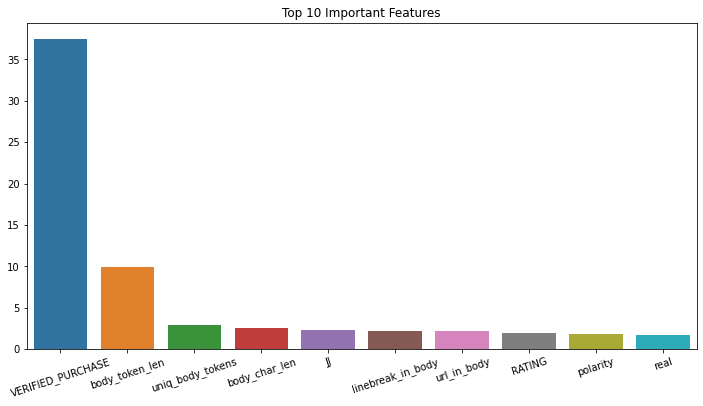

In [ ]:
## plotting top 10 feature importances
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(x=X_vals, y=y_vals, ax=ax)
ax.set_title("Top 10 Important Features");
plt.xticks(rotation=18);

# plt.savefig("feature_importance.svg", quality=95, optimize=True, format="svg")

In [ ]:
# from matplotlib import pyplot
# pyplot.bar([x for x in range(len(important_feet))], important_feet)
# pyplot.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

mlp = MLPClassifier()
mlp.fit(X_train,y_train)
y_preds = mlp.predict(X_test)

print(f"accuracy: \t{round(accuracy_score(y_test, y_preds)*100,4)}%")
print(f"precision: \t{round(precision_score(y_test, y_preds)*100,4)}%")
print(f"recall: \t{round(recall_score(y_test, y_preds)*100,4)}%")
print(f"ROC AUC: \t{round(roc_auc_score(y_test, y_preds)*100,4)}%")
print(f"F1 score: \t{round(f1_score(y_test, y_preds)*100,4)}%")

accuracy: 	80.2619%
precision: 	79.4622%
recall: 	81.619%
ROC AUC: 	80.2619%
F1 score: 	80.5262%


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

guas = GaussianNB()
guas.fit(X_train,y_train)
y_preds = guas.predict(X_test)

print(f"accuracy: \t{round(accuracy_score(y_test, y_preds)*100,4)}%")
print(f"precision: \t{round(precision_score(y_test, y_preds)*100,4)}%")
print(f"recall: \t{round(recall_score(y_test, y_preds)*100,4)}%")
print(f"ROC AUC: \t{round(roc_auc_score(y_test, y_preds)*100,4)}%")
print(f"F1 score: \t{round(f1_score(y_test, y_preds)*100,4)}%")

accuracy: 	55.619%
precision: 	70.7746%
recall: 	19.1429%
ROC AUC: 	55.619%
F1 score: 	30.1349%


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

sgd = SGDClassifier()
sgd.fit(X_train,y_train)
y_preds = sgd.predict(X_test)

print(f"accuracy: \t{round(accuracy_score(y_test, y_preds)*100,4)}%")
print(f"precision: \t{round(precision_score(y_test, y_preds)*100,4)}%")
print(f"recall: \t{round(recall_score(y_test, y_preds)*100,4)}%")
print(f"ROC AUC: \t{round(roc_auc_score(y_test, y_preds)*100,4)}%")
print(f"F1 score: \t{round(f1_score(y_test, y_preds)*100,4)}%")

accuracy: 	50.4524%
precision: 	50.2273%
recall: 	99.9524%
ROC AUC: 	50.4524%
F1 score: 	66.8578%


# Model Selection and Further Processing
- Best performing models (based on F1 score): XGBoost, RandomForest, MLP
- Principal Component Analysis
- GridSearch for performance boosts

In [ ]:
from sklearn.decomposition import PCA

n_comps = 20

pca = PCA(n_components=n_comps)

## dimensionality reduction on our data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

best_models = {"XGBoost": XGBClassifier(),
               "RandomForest": RandomForestClassifier(),
               "MLP": MLPClassifier()}

print(f"Models under PCA [{n_comps} Components]")

for i in best_models.items():
    clf = i[1].fit(X_train_pca, y_train)

    y_preds = clf.predict(X_test_pca)

    print(f"\t{i[0]}: {round(f1_score(y_preds, y_test),6)}")

### It seems that peforming PCA actually decreases F1 score, now getting a variable number of components to 
### see the effect as we increase n_comps. Let's find the optimal number of components to use

Getting PCA scores for our three models (XGB, MLP, RF), skipping every 5 components since we have so many features. 

In [ ]:
#### Principal Component Analysis (PCA) with variable number of components (jump every 5 comps in range function)
pca_scores_xgb = {}
pca_scores_mlp = {}
pca_scores_rf = {}

for i in range(1, len(X_train.columns.values), 5):
    pca = PCA(n_components=i)

    ## fit data into pca
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    # pca.explained_variance_
    
    ## get our xgb classifier results
    a = XGBClassifier()
    a.fit(X_train_pca, y_train)
    y_preds_xgb = a.predict(X_test_pca)

    pca_scores_xgb[i] = f1_score(y_preds_xgb, y_test)

    ## mlp classifier results
    b = MLPClassifier()
    b.fit(X_train_pca, y_train)
    y_preds_mlp = b.predict(X_test_pca)

    pca_scores_mlp[i] = f1_score(y_preds_mlp, y_test)

    ## rf classifier results
    c = RandomForestClassifier()
    c.fit(X_train_pca, y_train)
    y_preds_rf = c.predict(X_test_pca)

    pca_scores_rf[i] = f1_score(y_preds_rf, y_test)

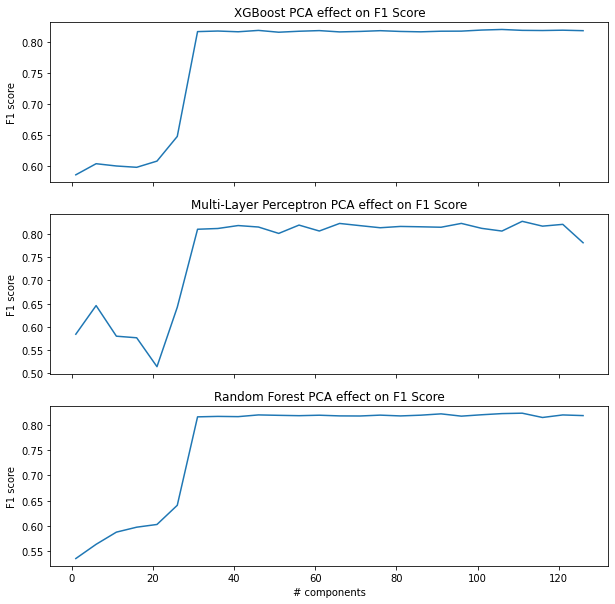

In [ ]:
## plotting these PCA scores and visually obsercing the plateau, we pick a number of components through this visual aid 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10), sharex=True)

## xgboost PCA viz
ax1.plot(list(pca_scores_xgb.keys()), list(pca_scores_xgb.values()))
ax1.set_title("XGBoost PCA effect on F1 Score")
ax1.set_ylabel("F1 score")
# ax1.set_xlabel("# components")

## mlp PCA viz
ax2.plot(list(pca_scores_mlp.keys()), list(pca_scores_mlp.values()))
ax2.set_title("Multi-Layer Perceptron PCA effect on F1 Score")
ax2.set_ylabel("F1 score")
# ax2.set_xlabel("# components")

## RF PCA viz
ax3.plot(list(pca_scores_rf.keys()), list(pca_scores_rf.values()))
ax3.set_title("Random Forest PCA effect on F1 Score")
ax3.set_ylabel("F1 score")
ax3.set_xlabel("# components");

plt.savefig("pca_explain.svg", quality=95, optimize=True, format="svg")

# pca_scores_xgb
# pca_scores_mlp
# pca_scores_rf

Just by seeing at the visualization, we can make the claim that choosing 30-35 components and get pretty good results (not 130 features anymore). This will help us achieve better computational efficiency at a very low cost.

### Principal Component Analysis (PCA)

In [ ]:
## Through the visual aid, we pick 35 principal components. We'll observe the performance on vanilla classifier, and further gridsearch these models to see model improvement
optimal_comps = 35

pca = PCA(n_components=optimal_comps)

## get train/test with 35 components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
## let's get the F1 score for our best models, to then GridSearch parameter tune
xgb_clf = XGBClassifier().fit(X_train_pca, y_train)
y_preds_xgb = xgb_clf.predict(X_test_pca)

print(f"XGB Classifier Performance with PCA")
print(f"accuracy @35: \t{round(accuracy_score(y_test, y_preds_xgb)*100,4)}%")
print(f"precision @35: \t{round(precision_score(y_test, y_preds_xgb)*100,4)}%")
print(f"recall @35: \t{round(recall_score(y_test, y_preds_xgb)*100,4)}%")
print(f"ROC AUC @35: \t{round(roc_auc_score(y_test, y_preds_xgb)*100,4)}%")
print(f"F1 score @35: \t{round(f1_score(y_test, y_preds_xgb)*100,4)}%")

XGB Classifier Performance with PCA
accuracy @35: 	79.8095%
precision @35: 	75.6979%
recall @35: 	87.8095%
ROC AUC @35: 	79.8095%
F1 score @35: 	81.3051%


In [ ]:
## doing vanilla random forest pca
rf_clf = RandomForestClassifier().fit(X_train_pca, y_train)
y_preds_rf = rf_clf.predict(X_test_pca)

print(f"Random Forest Performance with PCA")
print(f"accuracy @35: \t{round(accuracy_score(y_test, y_preds_rf)*100,4)}%")
print(f"precision @35: \t{round(precision_score(y_test, y_preds_rf)*100,4)}%")
print(f"recall @35: \t{round(recall_score(y_test, y_preds_rf)*100,4)}%")
print(f"ROC AUC @35: \t{round(roc_auc_score(y_test, y_preds_rf)*100,4)}%")
print(f"F1 score @35: \t{round(f1_score(y_test, y_preds_rf)*100,4)}%")

Random Forest Performance with PCA
accuracy @35: 	80.2857%
precision @35: 	76.0442%
recall @35: 	88.4286%
ROC AUC @35: 	80.2857%
F1 score @35: 	81.7701%


In [ ]:
## doing vanilla MLP with pca 
mlp_clf = MLPClassifier().fit(X_train_pca, y_train)
y_preds_mlp = mlp_clf.predict(X_test_pca)

print(f"Multi-Layer Perceptron Performance with PCA")
print(f"accuracy @35: \t{round(accuracy_score(y_test, y_preds_mlp)*100,4)}%")
print(f"precision @35: \t{round(precision_score(y_test, y_preds_mlp)*100,4)}%")
print(f"recall @35: \t{round(recall_score(y_test, y_preds_mlp)*100,4)}%")
print(f"ROC AUC @35: \t{round(roc_auc_score(y_test, y_preds_mlp)*100,4)}%")
print(f"F1 score @35: \t{round(f1_score(y_test, y_preds_mlp)*100,4)}%")

Multi-Layer Perceptron Performance with PCA
accuracy @35: 	80.0714%
precision @35: 	77.0218%
recall @35: 	85.7143%
ROC AUC @35: 	80.0714%
F1 score @35: 	81.1359%


### GridSearch and PCA

In [ ]:
## XGBoost parameter tuning
from sklearn.model_selection import GridSearchCV

N=35 # ideal number of components

clf_xgb = XGBClassifier()

## removed, to see if it's doable now:
    # 'subsample': [0.5, 0.7],
    # 'colsample_bytree': [0.5, 0.7],

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 5, 7],
    'min_child_weight': [1, 3, 5],
    'n_estimators' : [100, 200, 300],
    'objective': ['reg:squarederror', 'binary:logistic']
}   

cv_xgb = GridSearchCV(clf_xgb, param_grid, scoring="f1", n_jobs=-1)
cv_xgb.fit(X_train_pca, y_train)

print(f"Given {N} principal components")
print(f"Grid-Best Score: {round(cv_xgb.best_score_, 4)}")
print(f"Grid-Best Parameters: {cv_xgb.best_params_}")


Given 35 principal components
Grid-Best Score: 0.8108
Grid-Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'binary:logistic'}


In [ ]:
#### Pass best parameters to a classifier and check score

## note: this is accuracy, not f1. We already get g1 score using our grid-bet score since we establish scoring=f1
tuned_xgb = XGBClassifier(**cv_xgb.best_params_)
tuned_xgb.fit(X_train_pca, y_train)
print(tuned_xgb.score(X_test_pca, y_test))

0.7976190476190477


In [ ]:
## let's pickle the models too, JIC
from sklearn.externals import joblib 

joblib.dump(cv_xgb.best_estimator_, '/content/drive/Shareddrives/SI671 Project [Data Mining]/pickles/xgb_gs_best_estimator.pkl')
joblib.dump(cv_xgb, '/content/drive/Shareddrives/SI671 Project [Data Mining]/pickles/xgb_gs_model.pkl')


['/content/drive/Shareddrives/SI671 Project [Data Mining]/pickles/xgb_gs_model.pkl']

In [ ]:
## Random Forest parameter tuning w/ GridSearch
from sklearn.model_selection import GridSearchCV

N=35

clf_rf = RandomForestClassifier()

## removed to see if doable, again
            #   "min_samples_split": [2, 5, 7],
            #   "min_samples_leaf": [1, 2, 4]

param_grid = {"n_estimators": [100, 200, 250],
              "criterion": ["gini", "entropy"],
              "max_depth": [None, 7, 10], 
              "max_features": ["log2", "auto", "sqrt"]
              }

cv_rf = GridSearchCV(clf_rf, param_grid, scoring="f1", n_jobs=-1)
cv_rf.fit(X_train_pca, y_train)
print(f"Given {N} principal components")
print(f"Grid-Best Score: {round(cv_rf.best_score_, 4)}")
print(f"Grid-Best Parameters: {cv_rf.best_params_}")

Given 35 principal components
Grid-Best Score: 0.8132
Grid-Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 250}


In [ ]:
#### Pass best parameters to a classifier and check score
tuned_rf = RandomForestClassifier(**cv_rf.best_params_)
tuned_rf.fit(X_train_pca, y_train)
print(tuned_rf.score(X_test_pca, y_test))

0.8047619047619048


In [ ]:
from sklearn.externals import joblib 

joblib.dump(cv_rf.best_estimator_, '/content/drive/Shareddrives/SI671 Project [Data Mining]/pickles/rf_gs_best_estimator.pkl')
joblib.dump(cv_rf, '/content/drive/Shareddrives/SI671 Project [Data Mining]/pickles/rf_gs_model.pkl')

['/content/drive/Shareddrives/SI671 Project [Data Mining]/pickles/rf_gs_model.pkl']

In [ ]:
## MLP Classifier parameter tuning
from sklearn.model_selection import GridSearchCV

N=35

clf_mlp = MLPClassifier()

param_grid = {"activation": ["logistic", "relu", "tanh"],
              "solver": ["sgd", "adam"], 
              "alpha": [0.0001, 0.001, 0.01],
              "learning_rate": ["constant", "adaptive"]
              }

cv_mlp = GridSearchCV(clf_mlp, param_grid, scoring="f1", n_jobs=-1)
cv_mlp.fit(X_train_pca, y_train)

print(f"Given {N} principal components")
print(f"Grid-Best Score: {round(cv_mlp.best_score_, 4)}")
print(f"Grid-Best Parameters: {cv_mlp.best_params_}")

Given 35 principal components
Grid-Best Score: 0.8071
Grid-Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'solver': 'adam'}


In [ ]:
#### Pass best parameters to a classifier and check score
tuned_mlp = MLPClassifier(**cv_mlp.best_params_)
tuned_mlp.fit(X_train_pca, y_train)
print(tuned_mlp.score(X_test_pca, y_test))

0.7995238095238095


In [ ]:
from sklearn.externals import joblib 

joblib.dump(cv_mlp.best_estimator_, '/content/drive/Shareddrives/SI671 Project [Data Mining]/pickles/mlp_gs_best_estimator.pkl')
joblib.dump(cv_mlp, '/content/drive/Shareddrives/SI671 Project [Data Mining]/pickles/mlp_gs_model.pkl')

['/content/drive/Shareddrives/SI671 Project [Data Mining]/pickles/mlp_gs_model.pkl']

### Final Models
- Use the best parameters and model to build our final model
- Random Forest the best performing model 
- Let's be thorough and calculate performance metrics for MLP and XGBoost as well

In [ ]:
## FINAL XGB MODEL

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'binary:logistic'}

XGB_model = XGBClassifier(**best_params)

XGB_model.fit(X_train_pca, y_train)
y_XGB_preds = XGB_model.predict(X_test_pca)

In [ ]:
best_F1 = round(f1_score(y_test, y_XGB_preds)*100,4)
best_recall = round(recall_score(y_test, y_XGB_preds)*100, 4)
best_accuracy = round(accuracy_score(y_test, y_XGB_preds)*100, 4)
best_ROC_AUC = round(roc_auc_score(y_test, y_XGB_preds)*100, 4)
best_precision = round(precision_score(y_test, y_XGB_preds)*100, 4)

In [ ]:
print(f"Performance Metrics for XGBoost Classifier w/ tuned parameters:")
print(f"Best performing model (XGB) F1 score: {best_F1}")
print(f"Best performing model (XGB) Recall score: {best_recall}")
print(f"Best performing model (XGB) Precision score: {best_precision}")
print(f"Best performing model (XGB) ROC_AUC score: {best_ROC_AUC}")
print(f"Best performing model (XGB) Accuracy score: {best_accuracy}")



Performance Metrics for XGBoost Classifier w/ tuned parameters:
Best performing model (XGB) F1 score: 81.4798
Best performing model (XGB) Recall score: 87.0476
Best performing model (XGB) Precision score: 76.5815
Best performing model (XGB) ROC_AUC score: 80.2143
Best performing model (XGB) Accuracy score: 80.2143


In [ ]:
## FINAL RANDOM FOREST MODEL

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
best_params = {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 250}

RF_model = RandomForestClassifier(**best_params)

RF_model.fit(X_train_pca, y_train)
y_RF_preds = RF_model.predict(X_test_pca)

In [ ]:
best_F1 = round(f1_score(y_test, y_RF_preds)*100,4)
best_recall = round(recall_score(y_test, y_RF_preds)*100, 4)
best_accuracy = round(accuracy_score(y_test, y_RF_preds)*100, 4)
best_ROC_AUC = round(roc_auc_score(y_test, y_RF_preds)*100, 4)
best_precision = round(precision_score(y_test, y_RF_preds)*100, 4)

In [ ]:
print(f"Performance Metrics for Random Forest Classifier w/ tuned parameters:")
print(f"Best performing model (RF) F1 score: {best_F1}")
print(f"Best performing model (RF) Recall score: {best_recall}")
print(f"Best performing model (RF) Precision score: {best_precision}")
print(f"Best performing model (RF) ROC_AUC score: {best_ROC_AUC}")
print(f"Best performing model (RF) Accuracy score: {best_accuracy}")



Performance Metrics for Random Forest Classifier w/ tuned parameters:
Best performing model (RF) F1 score: 82.0457
Best performing model (RF) Recall score: 89.0
Best performing model (RF) Precision score: 76.0993
Best performing model (RF) ROC_AUC score: 80.5238
Best performing model (RF) Accuracy score: 80.5238


In [ ]:
## FINAL MLP CLASSIFIER MODEL

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
best_params = {'activation': 'relu', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'solver': 'adam'}

MLP_model = MLPClassifier(**best_params)

MLP_model.fit(X_train_pca, y_train)
y_MLP_preds = MLP_model.predict(X_test_pca)

In [ ]:
best_F1 = round(f1_score(y_test, y_MLP_preds)*100,4)
best_recall = round(recall_score(y_test, y_MLP_preds)*100, 4)
best_accuracy = round(accuracy_score(y_test, y_MLP_preds)*100, 4)
best_ROC_AUC = round(roc_auc_score(y_test, y_MLP_preds)*100, 4)
best_precision = round(precision_score(y_test, y_MLP_preds)*100, 4)

In [ ]:
print(f"Performance Metrics for Random Forest Classifier w/ tuned parameters:")
print(f"Best performing model (RF) F1 score: {best_F1}")
print(f"Best performing model (RF) Recall score: {best_recall}")
print(f"Best performing model (RF) Precision score: {best_precision}")
print(f"Best performing model (RF) ROC_AUC score: {best_ROC_AUC}")
print(f"Best performing model (RF) Accuracy score: {best_accuracy}")



Performance Metrics for Random Forest Classifier w/ tuned parameters:
Best performing model (RF) F1 score: 81.9454
Best performing model (RF) Recall score: 87.8571
Best performing model (RF) Precision score: 76.779
Best performing model (RF) ROC_AUC score: 80.6429
Best performing model (RF) Accuracy score: 80.6429
